# GAN Training

## imports

In [1]:
import os
import matplotlib.pyplot as plt
# import cv2
import numpy as np
from models.GAN import GAN
from utils.loaders import load_safari

from PIL import Image, ImageOps
from numpy import asarray


## Dataset construction 

In [2]:
directory = 'data/dataset'
directory_r = 'data/dataset_rework/'
definition_px = 128
count = 0
for filename in os.listdir(directory):
    count+=1
    
dataset = np.zeros([count*3,definition_px*definition_px])
count = 0

for filename in os.listdir(directory):
    f = os.path.join(directory,filename)
    # load the image
    im = np.array(Image.open(f).convert('L'))
    
    # Resize image and convert in greycolor
    load_img_rz = np.array(Image.fromarray(im).resize((definition_px,definition_px)))
    # Save the image in jpeg
    Image.fromarray(load_img_rz).save(directory_r + 'r_'+filename)
    # create Pillow image
    true_img = Image.fromarray(load_img_rz)
    #Flip image
    im_flip = ImageOps.flip(true_img)
    im_flip.save(directory_r + 'f_'+filename)
    load_img_flip = np.array(im_flip)
    #Mirror image
    im_mirror = ImageOps.mirror(true_img)
    im_mirror.save(directory_r + 'm_'+filename)
    load_img_mirror = np.array(im_mirror)
    
    
    rz = np.zeros([1,load_img_rz.size])
    flip = np.zeros([1,load_img_flip.size])
    mirror = np.zeros([1,load_img_mirror.size])
    k = 0
    for i in range(definition_px):
        for j in range(definition_px):
            rz[0,k] = load_img_rz[i,j]
            flip[0,k] = load_img_flip[i,j]
            mirror[0,k] = load_img_mirror[i,j]
            k+=1
            
    dataset[count,:] = rz[0,:]
    count +=1        
    dataset[count,:] = flip[0,:]
    count +=1   
    dataset[count,:] = mirror[0,:]
    count +=1   

np.save('./data/dataset_rework.npy', dataset)

In [2]:
# run params
SECTION = 'gan'
RUN_ID = '0012'
DATA_NAME = 'drawing'
RUN_FOLDER = 'D:/PTUT/run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #


## data

In [3]:
(x_train, y_train) = load_safari('dataset_python')

In [5]:
x_train.shape

(80000, 128, 128, 1)

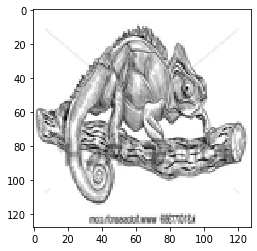

In [6]:
plt.imshow(x_train[200,:,:,0], cmap = 'gray')

## architecture

In [7]:
gan = GAN(input_dim = (128,128,1)
        , discriminator_conv_filters = [64,64,128,128]
        , discriminator_conv_kernel_size = [5,5,5,5]
        , discriminator_conv_strides = [2,2,2,1]
        , discriminator_batch_norm_momentum = None
        , discriminator_activation = 'relu'
        , discriminator_dropout_rate = 0.4
        , discriminator_learning_rate = 0.0008
        , generator_initial_dense_layer_size = (32, 32, 64)
        , generator_upsample = [2,2, 1, 1]
        , generator_conv_filters = [128,64, 64,1]
        , generator_conv_kernel_size = [5,5,5,5]
        , generator_conv_strides = [1,1, 1, 1]
        , generator_batch_norm_momentum = 0.9
        , generator_activation = 'relu'
        , generator_dropout_rate = None
        , generator_learning_rate = 0.0004
        , optimiser = 'rmsprop'
        , z_dim = 100
        )

if mode == 'build':
    gan.save(RUN_FOLDER)
else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [8]:
gan.discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa [(None, 128, 128, 1)]     0         
_________________________________________________________________
discriminator_conv_0 (Conv2D (None, 64, 64, 64)        1664      
_________________________________________________________________
activation (Activation)      (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
discriminator_conv_1 (Conv2D (None, 32, 32, 64)        102464    
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0     

In [9]:
gan.generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 65536)             6619136   
_________________________________________________________________
batch_normalization (BatchNo (None, 65536)             262144    
_________________________________________________________________
activation_4 (Activation)    (None, 65536)             0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 64)        0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
generator_conv_0 (Conv2D)    (None, 64, 64, 128)       2049

## training

In [10]:
BATCH_SIZE = 100
EPOCHS = 6000
PRINT_EVERY_N_BATCHES = 50

In [11]:
gan.train(     
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
)

0 [D loss: (1.246)(R 0.709, F 1.783)] [D acc: (0.185)(0.370, 0.000)] [G loss: 0.654] [G acc: 1.000]
1 [D loss: (0.670)(R 0.632, F 0.709)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.219] [G acc: 1.000]
2 [D loss: (8.757)(R 0.434, F 17.080)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.661] [G acc: 0.960]
3 [D loss: (0.583)(R 0.461, F 0.705)] [D acc: (0.515)(1.000, 0.030)] [G loss: 0.658] [G acc: 0.910]
4 [D loss: (0.405)(R 0.114, F 0.695)] [D acc: (0.550)(0.990, 0.110)] [G loss: 0.653] [G acc: 0.950]
5 [D loss: (0.359)(R 0.025, F 0.693)] [D acc: (0.765)(1.000, 0.530)] [G loss: 0.650] [G acc: 0.990]
6 [D loss: (0.358)(R 0.017, F 0.699)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.651] [G acc: 0.960]
7 [D loss: (0.394)(R 0.005, F 0.784)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.660] [G acc: 0.920]
8 [D loss: (0.460)(R 0.047, F 0.873)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.660] [G acc: 0.900]
9 [D loss: (0.511)(R 0.276, F 0.746)] [D acc: (0.525)(0.980, 0.070)] [G loss: 0.652] [G acc: 0.950]

82 [D loss: (0.652)(R 0.635, F 0.670)] [D acc: (0.785)(0.760, 0.810)] [G loss: 0.759] [G acc: 0.050]
83 [D loss: (0.635)(R 0.583, F 0.687)] [D acc: (0.720)(0.780, 0.660)] [G loss: 0.759] [G acc: 0.090]
84 [D loss: (0.642)(R 0.530, F 0.754)] [D acc: (0.675)(0.860, 0.490)] [G loss: 0.766] [G acc: 0.110]
85 [D loss: (0.680)(R 0.533, F 0.827)] [D acc: (0.595)(0.830, 0.360)] [G loss: 0.744] [G acc: 0.190]
86 [D loss: (0.667)(R 0.559, F 0.775)] [D acc: (0.565)(0.800, 0.330)] [G loss: 0.725] [G acc: 0.240]
87 [D loss: (0.637)(R 0.534, F 0.740)] [D acc: (0.695)(0.910, 0.480)] [G loss: 0.587] [G acc: 0.850]
88 [D loss: (0.635)(R 0.477, F 0.792)] [D acc: (0.640)(0.860, 0.420)] [G loss: 0.399] [G acc: 1.000]
89 [D loss: (0.547)(R 0.458, F 0.636)] [D acc: (0.855)(0.890, 0.820)] [G loss: 0.164] [G acc: 1.000]
90 [D loss: (0.407)(R 0.287, F 0.527)] [D acc: (0.970)(0.950, 0.990)] [G loss: 0.024] [G acc: 1.000]
91 [D loss: (0.378)(R 0.217, F 0.539)] [D acc: (0.950)(0.940, 0.960)] [G loss: 0.008] [G ac

163 [D loss: (0.654)(R 0.535, F 0.772)] [D acc: (0.480)(0.520, 0.440)] [G loss: 0.730] [G acc: 0.030]
164 [D loss: (0.627)(R 0.580, F 0.675)] [D acc: (0.725)(0.460, 0.990)] [G loss: 0.716] [G acc: 0.000]
165 [D loss: (0.586)(R 0.494, F 0.677)] [D acc: (0.765)(0.610, 0.920)] [G loss: 0.714] [G acc: 0.060]
166 [D loss: (2.704)(R 0.418, F 4.990)] [D acc: (0.385)(0.770, 0.000)] [G loss: 0.705] [G acc: 0.210]
167 [D loss: (0.699)(R 0.579, F 0.820)] [D acc: (0.340)(0.490, 0.190)] [G loss: 0.699] [G acc: 0.290]
168 [D loss: (1.184)(R 0.622, F 1.747)] [D acc: (0.160)(0.320, 0.000)] [G loss: 0.715] [G acc: 0.130]
169 [D loss: (0.697)(R 0.681, F 0.713)] [D acc: (0.325)(0.240, 0.410)] [G loss: 0.719] [G acc: 0.130]
170 [D loss: (0.691)(R 0.688, F 0.695)] [D acc: (0.350)(0.210, 0.490)] [G loss: 0.725] [G acc: 0.040]
171 [D loss: (0.687)(R 0.694, F 0.680)] [D acc: (0.460)(0.110, 0.810)] [G loss: 0.717] [G acc: 0.010]
172 [D loss: (0.674)(R 0.672, F 0.676)] [D acc: (0.570)(0.180, 0.960)] [G loss: 0.

244 [D loss: (0.590)(R 0.514, F 0.666)] [D acc: (0.765)(0.570, 0.960)] [G loss: 0.732] [G acc: 0.000]
245 [D loss: (1.069)(R 0.432, F 1.706)] [D acc: (0.395)(0.670, 0.120)] [G loss: 0.724] [G acc: 0.000]
246 [D loss: (0.653)(R 0.629, F 0.678)] [D acc: (0.585)(0.300, 0.870)] [G loss: 0.734] [G acc: 0.000]
247 [D loss: (0.654)(R 0.636, F 0.673)] [D acc: (0.595)(0.300, 0.890)] [G loss: 0.727] [G acc: 0.010]
248 [D loss: (0.647)(R 0.627, F 0.668)] [D acc: (0.605)(0.290, 0.920)] [G loss: 0.726] [G acc: 0.000]
249 [D loss: (0.631)(R 0.595, F 0.667)] [D acc: (0.645)(0.310, 0.980)] [G loss: 0.730] [G acc: 0.010]
250 [D loss: (0.608)(R 0.530, F 0.687)] [D acc: (0.625)(0.530, 0.720)] [G loss: 0.729] [G acc: 0.000]
251 [D loss: (0.665)(R 0.642, F 0.688)] [D acc: (0.515)(0.290, 0.740)] [G loss: 0.723] [G acc: 0.080]
252 [D loss: (0.758)(R 0.560, F 0.956)] [D acc: (0.415)(0.370, 0.460)] [G loss: 0.725] [G acc: 0.040]
253 [D loss: (0.630)(R 0.592, F 0.667)] [D acc: (0.645)(0.310, 0.980)] [G loss: 0.

325 [D loss: (5.766)(R 0.472, F 11.061)] [D acc: (0.255)(0.500, 0.010)] [G loss: 0.763] [G acc: 0.150]
326 [D loss: (0.677)(R 0.712, F 0.643)] [D acc: (0.590)(0.330, 0.850)] [G loss: 0.714] [G acc: 0.390]
327 [D loss: (0.743)(R 0.723, F 0.762)] [D acc: (0.345)(0.470, 0.220)] [G loss: 0.696] [G acc: 0.410]
328 [D loss: (0.715)(R 0.683, F 0.748)] [D acc: (0.275)(0.470, 0.080)] [G loss: 0.725] [G acc: 0.000]
329 [D loss: (0.684)(R 0.699, F 0.668)] [D acc: (0.565)(0.160, 0.970)] [G loss: 0.727] [G acc: 0.010]
330 [D loss: (0.680)(R 0.689, F 0.670)] [D acc: (0.565)(0.190, 0.940)] [G loss: 0.731] [G acc: 0.000]
331 [D loss: (0.648)(R 0.633, F 0.662)] [D acc: (0.630)(0.270, 0.990)] [G loss: 0.734] [G acc: 0.010]
332 [D loss: (0.646)(R 0.634, F 0.659)] [D acc: (0.660)(0.330, 0.990)] [G loss: 0.740] [G acc: 0.000]
333 [D loss: (0.643)(R 0.625, F 0.660)] [D acc: (0.660)(0.340, 0.980)] [G loss: 0.741] [G acc: 0.000]
334 [D loss: (0.619)(R 0.581, F 0.656)] [D acc: (0.715)(0.440, 0.990)] [G loss: 0

406 [D loss: (0.245)(R 0.324, F 0.167)] [D acc: (0.985)(0.970, 1.000)] [G loss: 5.916] [G acc: 0.000]
407 [D loss: (41.200)(R 0.000, F 82.400)] [D acc: (0.500)(1.000, 0.000)] [G loss: 8.668] [G acc: 0.000]
408 [D loss: (8.737)(R 6.129, F 11.345)] [D acc: (0.030)(0.060, 0.000)] [G loss: 0.644] [G acc: 0.620]
409 [D loss: (1.232)(R 0.361, F 2.103)] [D acc: (0.460)(0.830, 0.090)] [G loss: 1.202] [G acc: 0.230]
410 [D loss: (1.062)(R 0.988, F 1.135)] [D acc: (0.345)(0.380, 0.310)] [G loss: 1.006] [G acc: 0.210]
411 [D loss: (0.882)(R 0.925, F 0.840)] [D acc: (0.385)(0.340, 0.430)] [G loss: 0.791] [G acc: 0.370]
412 [D loss: (0.485)(R 0.715, F 0.255)] [D acc: (0.770)(0.540, 1.000)] [G loss: 0.410] [G acc: 0.940]
413 [D loss: (0.266)(R 0.479, F 0.053)] [D acc: (0.920)(0.840, 1.000)] [G loss: 0.211] [G acc: 0.990]
414 [D loss: (0.176)(R 0.320, F 0.033)] [D acc: (0.955)(0.910, 1.000)] [G loss: 0.124] [G acc: 1.000]
415 [D loss: (0.130)(R 0.234, F 0.027)] [D acc: (0.960)(0.920, 1.000)] [G loss:

487 [D loss: (0.687)(R 0.686, F 0.687)] [D acc: (0.530)(0.520, 0.540)] [G loss: 0.743] [G acc: 0.260]
488 [D loss: (0.693)(R 0.720, F 0.666)] [D acc: (0.535)(0.400, 0.670)] [G loss: 0.725] [G acc: 0.380]
489 [D loss: (0.637)(R 0.603, F 0.671)] [D acc: (0.545)(0.430, 0.660)] [G loss: 0.687] [G acc: 0.420]
490 [D loss: (0.636)(R 0.614, F 0.657)] [D acc: (0.525)(0.370, 0.680)] [G loss: 0.591] [G acc: 0.470]
491 [D loss: (0.688)(R 0.672, F 0.704)] [D acc: (0.550)(0.350, 0.750)] [G loss: 0.611] [G acc: 0.420]
492 [D loss: (0.670)(R 0.618, F 0.722)] [D acc: (0.560)(0.380, 0.740)] [G loss: 0.529] [G acc: 0.580]
493 [D loss: (0.736)(R 0.650, F 0.821)] [D acc: (0.535)(0.270, 0.800)] [G loss: 0.574] [G acc: 0.530]
494 [D loss: (0.814)(R 0.650, F 0.977)] [D acc: (0.545)(0.320, 0.770)] [G loss: 0.539] [G acc: 0.610]
495 [D loss: (0.875)(R 0.606, F 1.143)] [D acc: (0.510)(0.320, 0.700)] [G loss: 0.625] [G acc: 0.420]
496 [D loss: (0.772)(R 0.709, F 0.835)] [D acc: (0.485)(0.210, 0.760)] [G loss: 0.

568 [D loss: (0.661)(R 0.688, F 0.633)] [D acc: (0.595)(0.210, 0.980)] [G loss: 0.795] [G acc: 0.010]
569 [D loss: (0.670)(R 0.706, F 0.634)] [D acc: (0.600)(0.200, 1.000)] [G loss: 0.758] [G acc: 0.000]
570 [D loss: (0.653)(R 0.672, F 0.634)] [D acc: (0.605)(0.210, 1.000)] [G loss: 0.757] [G acc: 0.000]
571 [D loss: (0.638)(R 0.642, F 0.634)] [D acc: (0.620)(0.240, 1.000)] [G loss: 0.757] [G acc: 0.000]
572 [D loss: (0.648)(R 0.662, F 0.635)] [D acc: (0.605)(0.220, 0.990)] [G loss: 0.757] [G acc: 0.000]
573 [D loss: (0.645)(R 0.656, F 0.634)] [D acc: (0.620)(0.250, 0.990)] [G loss: 0.756] [G acc: 0.000]
574 [D loss: (0.627)(R 0.570, F 0.683)] [D acc: (0.535)(0.370, 0.700)] [G loss: 0.757] [G acc: 0.000]
575 [D loss: (0.673)(R 0.490, F 0.857)] [D acc: (0.300)(0.570, 0.030)] [G loss: 0.756] [G acc: 0.010]
576 [D loss: (0.607)(R 0.572, F 0.642)] [D acc: (0.655)(0.380, 0.930)] [G loss: 0.754] [G acc: 0.020]
577 [D loss: (0.615)(R 0.527, F 0.703)] [D acc: (0.555)(0.480, 0.630)] [G loss: 0.

649 [D loss: (0.663)(R 0.651, F 0.675)] [D acc: (0.530)(0.390, 0.670)] [G loss: 0.739] [G acc: 0.230]
650 [D loss: (0.653)(R 0.633, F 0.673)] [D acc: (0.500)(0.360, 0.640)] [G loss: 0.746] [G acc: 0.150]
651 [D loss: (0.656)(R 0.626, F 0.686)] [D acc: (0.500)(0.400, 0.600)] [G loss: 0.741] [G acc: 0.130]
652 [D loss: (0.644)(R 0.629, F 0.658)] [D acc: (0.545)(0.320, 0.770)] [G loss: 0.752] [G acc: 0.110]
653 [D loss: (0.636)(R 0.618, F 0.654)] [D acc: (0.605)(0.360, 0.850)] [G loss: 0.743] [G acc: 0.130]
654 [D loss: (0.632)(R 0.613, F 0.650)] [D acc: (0.605)(0.350, 0.860)] [G loss: 0.766] [G acc: 0.010]
655 [D loss: (0.979)(R 0.595, F 1.364)] [D acc: (0.235)(0.420, 0.050)] [G loss: 0.647] [G acc: 0.700]
656 [D loss: (0.743)(R 0.552, F 0.933)] [D acc: (0.400)(0.730, 0.070)] [G loss: 0.701] [G acc: 0.430]
657 [D loss: (0.630)(R 0.551, F 0.708)] [D acc: (0.525)(0.570, 0.480)] [G loss: 0.716] [G acc: 0.250]
658 [D loss: (0.616)(R 0.569, F 0.663)] [D acc: (0.615)(0.400, 0.830)] [G loss: 0.

730 [D loss: (0.696)(R 0.770, F 0.623)] [D acc: (0.505)(0.010, 1.000)] [G loss: 0.769] [G acc: 0.000]
731 [D loss: (0.696)(R 0.770, F 0.623)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.771] [G acc: 0.000]
732 [D loss: (0.697)(R 0.771, F 0.623)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.769] [G acc: 0.000]
733 [D loss: (0.696)(R 0.770, F 0.623)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.769] [G acc: 0.000]
734 [D loss: (0.696)(R 0.769, F 0.623)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.769] [G acc: 0.000]
735 [D loss: (0.696)(R 0.769, F 0.623)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.769] [G acc: 0.000]
736 [D loss: (0.697)(R 0.769, F 0.624)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.769] [G acc: 0.000]
737 [D loss: (0.696)(R 0.769, F 0.623)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.769] [G acc: 0.000]
738 [D loss: (0.695)(R 0.769, F 0.621)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.824] [G acc: 0.010]
739 [D loss: (0.703)(R 0.783, F 0.623)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.

811 [D loss: (0.696)(R 0.765, F 0.627)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.764] [G acc: 0.000]
812 [D loss: (0.696)(R 0.764, F 0.627)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.764] [G acc: 0.000]
813 [D loss: (0.696)(R 0.764, F 0.627)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.764] [G acc: 0.000]
814 [D loss: (0.696)(R 0.764, F 0.627)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.764] [G acc: 0.000]
815 [D loss: (0.696)(R 0.764, F 0.627)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.764] [G acc: 0.000]
816 [D loss: (0.696)(R 0.764, F 0.627)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.764] [G acc: 0.000]
817 [D loss: (0.696)(R 0.764, F 0.627)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.764] [G acc: 0.000]
818 [D loss: (0.696)(R 0.764, F 0.627)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.764] [G acc: 0.000]
819 [D loss: (0.696)(R 0.764, F 0.627)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.764] [G acc: 0.000]
820 [D loss: (0.696)(R 0.764, F 0.627)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.

892 [D loss: (0.684)(R 0.728, F 0.640)] [D acc: (0.555)(0.120, 0.990)] [G loss: 0.757] [G acc: 0.000]
893 [D loss: (0.673)(R 0.713, F 0.634)] [D acc: (0.580)(0.160, 1.000)] [G loss: 0.754] [G acc: 0.020]
894 [D loss: (0.659)(R 0.665, F 0.654)] [D acc: (0.580)(0.280, 0.880)] [G loss: 0.755] [G acc: 0.000]
895 [D loss: (0.652)(R 0.665, F 0.639)] [D acc: (0.600)(0.220, 0.980)] [G loss: 0.758] [G acc: 0.000]
896 [D loss: (0.654)(R 0.676, F 0.633)] [D acc: (0.660)(0.320, 1.000)] [G loss: 0.757] [G acc: 0.000]
897 [D loss: (0.737)(R 0.654, F 0.820)] [D acc: (0.205)(0.280, 0.130)] [G loss: 0.747] [G acc: 0.070]
898 [D loss: (0.668)(R 0.679, F 0.657)] [D acc: (0.540)(0.200, 0.880)] [G loss: 0.759] [G acc: 0.000]
899 [D loss: (0.635)(R 0.637, F 0.632)] [D acc: (0.615)(0.230, 1.000)] [G loss: 0.759] [G acc: 0.000]
900 [D loss: (0.605)(R 0.577, F 0.633)] [D acc: (0.660)(0.320, 1.000)] [G loss: 0.759] [G acc: 0.000]
901 [D loss: (0.579)(R 0.526, F 0.632)] [D acc: (0.725)(0.450, 1.000)] [G loss: 0.

973 [D loss: (0.695)(R 0.762, F 0.628)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.762] [G acc: 0.000]
974 [D loss: (0.695)(R 0.762, F 0.629)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.762] [G acc: 0.000]
975 [D loss: (0.699)(R 0.762, F 0.636)] [D acc: (0.480)(0.000, 0.960)] [G loss: 0.764] [G acc: 0.000]
976 [D loss: (0.696)(R 0.764, F 0.629)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.762] [G acc: 0.000]
977 [D loss: (0.696)(R 0.764, F 0.629)] [D acc: (0.505)(0.010, 1.000)] [G loss: 0.763] [G acc: 0.000]
978 [D loss: (0.696)(R 0.762, F 0.629)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.762] [G acc: 0.000]
979 [D loss: (0.699)(R 0.765, F 0.633)] [D acc: (0.495)(0.000, 0.990)] [G loss: 0.762] [G acc: 0.000]
980 [D loss: (0.695)(R 0.762, F 0.629)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.762] [G acc: 0.000]
981 [D loss: (0.696)(R 0.762, F 0.629)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.762] [G acc: 0.000]
982 [D loss: (0.696)(R 0.762, F 0.630)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.

1053 [D loss: (0.695)(R 0.758, F 0.633)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.758] [G acc: 0.000]
1054 [D loss: (0.695)(R 0.758, F 0.633)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.758] [G acc: 0.000]
1055 [D loss: (0.695)(R 0.758, F 0.633)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.758] [G acc: 0.000]
1056 [D loss: (0.695)(R 0.758, F 0.633)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.758] [G acc: 0.000]
1057 [D loss: (0.695)(R 0.758, F 0.633)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.758] [G acc: 0.000]
1058 [D loss: (0.695)(R 0.758, F 0.633)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.758] [G acc: 0.000]
1059 [D loss: (0.695)(R 0.758, F 0.633)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.758] [G acc: 0.000]
1060 [D loss: (0.695)(R 0.758, F 0.633)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.758] [G acc: 0.000]
1061 [D loss: (0.695)(R 0.758, F 0.633)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.758] [G acc: 0.000]
1062 [D loss: (0.695)(R 0.758, F 0.633)] [D acc: (0.500)(0.000, 1.000)] [

1133 [D loss: (0.695)(R 0.755, F 0.635)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.755] [G acc: 0.000]
1134 [D loss: (0.695)(R 0.755, F 0.635)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.755] [G acc: 0.000]
1135 [D loss: (0.695)(R 0.755, F 0.635)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.755] [G acc: 0.000]
1136 [D loss: (0.695)(R 0.755, F 0.636)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.755] [G acc: 0.000]
1137 [D loss: (0.695)(R 0.755, F 0.636)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.755] [G acc: 0.000]
1138 [D loss: (0.695)(R 0.755, F 0.636)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.755] [G acc: 0.000]
1139 [D loss: (0.695)(R 0.755, F 0.636)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.755] [G acc: 0.000]
1140 [D loss: (0.695)(R 0.755, F 0.636)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.755] [G acc: 0.000]
1141 [D loss: (0.695)(R 0.755, F 0.636)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.754] [G acc: 0.000]
1142 [D loss: (0.695)(R 0.755, F 0.636)] [D acc: (0.500)(0.000, 1.000)] [

1213 [D loss: (0.794)(R 0.562, F 1.026)] [D acc: (0.555)(0.320, 0.790)] [G loss: 0.226] [G acc: 0.870]
1214 [D loss: (0.738)(R 0.733, F 0.743)] [D acc: (0.475)(0.060, 0.890)] [G loss: 0.538] [G acc: 0.590]
1215 [D loss: (0.700)(R 0.742, F 0.657)] [D acc: (0.500)(0.040, 0.960)] [G loss: 0.362] [G acc: 0.760]
1216 [D loss: (0.714)(R 0.710, F 0.717)] [D acc: (0.480)(0.080, 0.880)] [G loss: 0.644] [G acc: 0.430]
1217 [D loss: (0.695)(R 0.752, F 0.638)] [D acc: (0.495)(0.000, 0.990)] [G loss: 0.656] [G acc: 0.370]
1218 [D loss: (0.701)(R 0.750, F 0.653)] [D acc: (0.490)(0.020, 0.960)] [G loss: 0.720] [G acc: 0.190]
1219 [D loss: (0.703)(R 0.752, F 0.655)] [D acc: (0.485)(0.010, 0.960)] [G loss: 0.754] [G acc: 0.000]
1220 [D loss: (0.694)(R 0.753, F 0.636)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.780] [G acc: 0.020]
1221 [D loss: (0.695)(R 0.756, F 0.634)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.803] [G acc: 0.000]
1222 [D loss: (0.696)(R 0.758, F 0.634)] [D acc: (0.500)(0.000, 1.000)] [

1293 [D loss: (0.708)(R 0.790, F 0.627)] [D acc: (0.495)(0.000, 0.990)] [G loss: 0.801] [G acc: 0.010]
1294 [D loss: (0.696)(R 0.770, F 0.621)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.831] [G acc: 0.000]
1295 [D loss: (0.688)(R 0.765, F 0.612)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.874] [G acc: 0.000]
1296 [D loss: (0.691)(R 0.783, F 0.600)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.948] [G acc: 0.000]
1297 [D loss: (0.696)(R 0.798, F 0.594)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.895] [G acc: 0.000]
1298 [D loss: (0.692)(R 0.790, F 0.594)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.870] [G acc: 0.000]
1299 [D loss: (0.688)(R 0.792, F 0.583)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.892] [G acc: 0.000]
1300 [D loss: (0.710)(R 0.823, F 0.597)] [D acc: (0.505)(0.010, 1.000)] [G loss: 0.789] [G acc: 0.000]
1301 [D loss: (0.697)(R 0.794, F 0.600)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.792] [G acc: 0.000]
1302 [D loss: (0.685)(R 0.764, F 0.605)] [D acc: (0.500)(0.000, 1.000)] [

1373 [D loss: (0.641)(R 0.638, F 0.645)] [D acc: (0.590)(0.210, 0.970)] [G loss: 0.750] [G acc: 0.010]
1374 [D loss: (1.799)(R 0.580, F 3.018)] [D acc: (0.225)(0.320, 0.130)] [G loss: 0.744] [G acc: 0.050]
1375 [D loss: (0.842)(R 0.680, F 1.003)] [D acc: (0.420)(0.130, 0.710)] [G loss: 0.750] [G acc: 0.130]
1376 [D loss: (0.745)(R 0.702, F 0.788)] [D acc: (0.375)(0.160, 0.590)] [G loss: 0.769] [G acc: 0.030]
1377 [D loss: (0.685)(R 0.732, F 0.637)] [D acc: (0.515)(0.070, 0.960)] [G loss: 0.776] [G acc: 0.010]
1378 [D loss: (0.693)(R 0.750, F 0.636)] [D acc: (0.515)(0.040, 0.990)] [G loss: 0.770] [G acc: 0.040]
1379 [D loss: (0.680)(R 0.721, F 0.639)] [D acc: (0.520)(0.070, 0.970)] [G loss: 0.771] [G acc: 0.070]
1380 [D loss: (0.690)(R 0.740, F 0.640)] [D acc: (0.520)(0.060, 0.980)] [G loss: 0.725] [G acc: 0.150]
1381 [D loss: (0.690)(R 0.740, F 0.640)] [D acc: (0.515)(0.060, 0.970)] [G loss: 0.495] [G acc: 0.640]
1382 [D loss: (0.691)(R 0.746, F 0.637)] [D acc: (0.515)(0.040, 0.990)] [

1453 [D loss: (0.693)(R 0.759, F 0.628)] [D acc: (0.500)(0.000, 1.000)] [G loss: 0.754] [G acc: 0.010]
1454 [D loss: (0.703)(R 0.772, F 0.635)] [D acc: (0.520)(0.040, 1.000)] [G loss: 0.756] [G acc: 0.000]
1455 [D loss: (0.689)(R 0.743, F 0.635)] [D acc: (0.515)(0.030, 1.000)] [G loss: 0.754] [G acc: 0.010]
1456 [D loss: (0.687)(R 0.739, F 0.635)] [D acc: (0.510)(0.030, 0.990)] [G loss: 0.756] [G acc: 0.000]
1457 [D loss: (0.691)(R 0.740, F 0.642)] [D acc: (0.515)(0.050, 0.980)] [G loss: 0.756] [G acc: 0.000]
1458 [D loss: (0.684)(R 0.716, F 0.651)] [D acc: (0.525)(0.100, 0.950)] [G loss: 0.755] [G acc: 0.000]
1459 [D loss: (0.681)(R 0.725, F 0.636)] [D acc: (0.540)(0.090, 0.990)] [G loss: 0.756] [G acc: 0.000]
1460 [D loss: (0.714)(R 0.726, F 0.701)] [D acc: (0.510)(0.080, 0.940)] [G loss: 0.756] [G acc: 0.000]
1461 [D loss: (0.684)(R 0.734, F 0.635)] [D acc: (0.520)(0.040, 1.000)] [G loss: 0.753] [G acc: 0.010]
1462 [D loss: (0.697)(R 0.753, F 0.640)] [D acc: (0.500)(0.020, 0.980)] [

1533 [D loss: (0.869)(R 1.123, F 0.615)] [D acc: (0.510)(0.050, 0.970)] [G loss: 0.740] [G acc: 0.110]
1534 [D loss: (0.708)(R 0.791, F 0.624)] [D acc: (0.515)(0.080, 0.950)] [G loss: 0.744] [G acc: 0.130]
1535 [D loss: (0.709)(R 0.788, F 0.629)] [D acc: (0.520)(0.090, 0.950)] [G loss: 0.743] [G acc: 0.110]
1536 [D loss: (0.716)(R 0.800, F 0.632)] [D acc: (0.520)(0.080, 0.960)] [G loss: 0.757] [G acc: 0.060]
1537 [D loss: (0.743)(R 0.838, F 0.647)] [D acc: (0.485)(0.070, 0.900)] [G loss: 0.751] [G acc: 0.040]
1538 [D loss: (0.712)(R 0.764, F 0.660)] [D acc: (0.480)(0.090, 0.870)] [G loss: 0.756] [G acc: 0.020]
1539 [D loss: (0.701)(R 0.761, F 0.640)] [D acc: (0.500)(0.050, 0.950)] [G loss: 0.756] [G acc: 0.050]
1540 [D loss: (0.712)(R 0.786, F 0.638)] [D acc: (0.540)(0.090, 0.990)] [G loss: 0.748] [G acc: 0.030]
1541 [D loss: (0.688)(R 0.739, F 0.637)] [D acc: (0.540)(0.100, 0.980)] [G loss: 0.747] [G acc: 0.050]
1542 [D loss: (0.688)(R 0.726, F 0.649)] [D acc: (0.520)(0.130, 0.910)] [

1613 [D loss: (0.689)(R 0.747, F 0.631)] [D acc: (0.525)(0.070, 0.980)] [G loss: 0.762] [G acc: 0.010]
1614 [D loss: (0.674)(R 0.716, F 0.633)] [D acc: (0.565)(0.130, 1.000)] [G loss: 0.760] [G acc: 0.000]
1615 [D loss: (0.641)(R 0.655, F 0.626)] [D acc: (0.625)(0.260, 0.990)] [G loss: 0.764] [G acc: 0.010]
1616 [D loss: (0.604)(R 0.443, F 0.764)] [D acc: (0.570)(0.600, 0.540)] [G loss: 0.760] [G acc: 0.000]
1617 [D loss: (0.625)(R 0.623, F 0.626)] [D acc: (0.670)(0.340, 1.000)] [G loss: 0.777] [G acc: 0.030]
1618 [D loss: (0.602)(R 0.582, F 0.622)] [D acc: (0.690)(0.470, 0.910)] [G loss: 0.839] [G acc: 0.080]
1619 [D loss: (0.749)(R 0.416, F 1.083)] [D acc: (0.565)(0.680, 0.450)] [G loss: 0.754] [G acc: 0.030]
1620 [D loss: (0.592)(R 0.524, F 0.660)] [D acc: (0.640)(0.430, 0.850)] [G loss: 0.774] [G acc: 0.050]
1621 [D loss: (0.504)(R 0.377, F 0.632)] [D acc: (0.785)(0.650, 0.920)] [G loss: 0.800] [G acc: 0.030]
1622 [D loss: (12.464)(R 0.265, F 24.663)] [D acc: (0.390)(0.770, 0.010)]

1693 [D loss: (0.647)(R 0.662, F 0.632)] [D acc: (0.570)(0.190, 0.950)] [G loss: 0.795] [G acc: 0.010]
1694 [D loss: (0.644)(R 0.661, F 0.628)] [D acc: (0.615)(0.240, 0.990)] [G loss: 0.766] [G acc: 0.000]
1695 [D loss: (0.617)(R 0.613, F 0.621)] [D acc: (0.680)(0.360, 1.000)] [G loss: 0.767] [G acc: 0.000]
1696 [D loss: (0.605)(R 0.576, F 0.633)] [D acc: (0.705)(0.430, 0.980)] [G loss: 0.770] [G acc: 0.000]
1697 [D loss: (0.581)(R 0.529, F 0.634)] [D acc: (0.725)(0.490, 0.960)] [G loss: 0.767] [G acc: 0.020]
1698 [D loss: (0.591)(R 0.550, F 0.632)] [D acc: (0.750)(0.520, 0.980)] [G loss: 0.768] [G acc: 0.000]
1699 [D loss: (0.554)(R 0.476, F 0.631)] [D acc: (0.750)(0.530, 0.970)] [G loss: 0.763] [G acc: 0.010]
1700 [D loss: (0.725)(R 0.418, F 1.032)] [D acc: (0.330)(0.620, 0.040)] [G loss: 0.737] [G acc: 0.180]
1701 [D loss: (0.614)(R 0.519, F 0.710)] [D acc: (0.535)(0.490, 0.580)] [G loss: 0.767] [G acc: 0.000]
1702 [D loss: (0.586)(R 0.547, F 0.625)] [D acc: (0.720)(0.440, 1.000)] [

1773 [D loss: (0.691)(R 0.746, F 0.635)] [D acc: (0.525)(0.110, 0.940)] [G loss: 0.763] [G acc: 0.080]
1774 [D loss: (0.682)(R 0.723, F 0.640)] [D acc: (0.530)(0.150, 0.910)] [G loss: 0.728] [G acc: 0.180]
1775 [D loss: (0.688)(R 0.730, F 0.646)] [D acc: (0.510)(0.140, 0.880)] [G loss: 0.724] [G acc: 0.200]
1776 [D loss: (0.676)(R 0.721, F 0.631)] [D acc: (0.535)(0.140, 0.930)] [G loss: 0.654] [G acc: 0.350]
1777 [D loss: (0.795)(R 0.718, F 0.872)] [D acc: (0.310)(0.130, 0.490)] [G loss: 0.747] [G acc: 0.240]
1778 [D loss: (0.713)(R 0.774, F 0.652)] [D acc: (0.435)(0.020, 0.850)] [G loss: 0.775] [G acc: 0.290]
1779 [D loss: (0.709)(R 0.749, F 0.668)] [D acc: (0.440)(0.090, 0.790)] [G loss: 0.922] [G acc: 0.180]
1780 [D loss: (0.862)(R 0.765, F 0.960)] [D acc: (0.305)(0.050, 0.560)] [G loss: 0.888] [G acc: 0.110]
1781 [D loss: (0.711)(R 0.831, F 0.590)] [D acc: (0.500)(0.040, 0.960)] [G loss: 0.911] [G acc: 0.060]
1782 [D loss: (0.693)(R 0.794, F 0.591)] [D acc: (0.475)(0.050, 0.900)] [

1853 [D loss: (0.382)(R 0.331, F 0.432)] [D acc: (0.860)(0.880, 0.840)] [G loss: 0.075] [G acc: 0.970]
1854 [D loss: (13.685)(R 0.517, F 26.853)] [D acc: (0.375)(0.750, 0.000)] [G loss: 0.963] [G acc: 0.110]
1855 [D loss: (0.741)(R 0.961, F 0.521)] [D acc: (0.600)(0.210, 0.990)] [G loss: 0.526] [G acc: 0.870]
1856 [D loss: (0.695)(R 0.819, F 0.572)] [D acc: (0.625)(0.260, 0.990)] [G loss: 0.412] [G acc: 0.980]
1857 [D loss: (0.580)(R 0.535, F 0.625)] [D acc: (0.700)(0.570, 0.830)] [G loss: 0.707] [G acc: 0.390]
1858 [D loss: (0.478)(R 0.400, F 0.556)] [D acc: (0.800)(0.620, 0.980)] [G loss: 0.850] [G acc: 0.010]
1859 [D loss: (0.343)(R 0.184, F 0.502)] [D acc: (0.925)(0.880, 0.970)] [G loss: 1.036] [G acc: 0.000]
1860 [D loss: (0.494)(R 0.165, F 0.822)] [D acc: (0.645)(0.920, 0.370)] [G loss: 0.043] [G acc: 1.000]
1861 [D loss: (2.704)(R 0.288, F 5.121)] [D acc: (0.450)(0.900, 0.000)] [G loss: 0.739] [G acc: 0.230]
1862 [D loss: (0.523)(R 0.405, F 0.641)] [D acc: (0.765)(0.650, 0.880)]

1933 [D loss: (0.683)(R 0.760, F 0.607)] [D acc: (0.530)(0.080, 0.980)] [G loss: 0.802] [G acc: 0.040]
1934 [D loss: (0.695)(R 0.769, F 0.621)] [D acc: (0.510)(0.080, 0.940)] [G loss: 0.796] [G acc: 0.030]
1935 [D loss: (0.681)(R 0.744, F 0.618)] [D acc: (0.515)(0.090, 0.940)] [G loss: 0.803] [G acc: 0.010]
1936 [D loss: (0.673)(R 0.730, F 0.617)] [D acc: (0.535)(0.100, 0.970)] [G loss: 0.790] [G acc: 0.020]
1937 [D loss: (0.713)(R 0.787, F 0.638)] [D acc: (0.505)(0.070, 0.940)] [G loss: 0.791] [G acc: 0.010]
1938 [D loss: (0.680)(R 0.746, F 0.614)] [D acc: (0.550)(0.120, 0.980)] [G loss: 0.792] [G acc: 0.010]
1939 [D loss: (0.677)(R 0.699, F 0.655)] [D acc: (0.535)(0.130, 0.940)] [G loss: 0.786] [G acc: 0.000]
1940 [D loss: (0.679)(R 0.751, F 0.608)] [D acc: (0.540)(0.090, 0.990)] [G loss: 0.784] [G acc: 0.030]
1941 [D loss: (0.657)(R 0.693, F 0.622)] [D acc: (0.550)(0.140, 0.960)] [G loss: 0.783] [G acc: 0.020]
1942 [D loss: (0.672)(R 0.731, F 0.613)] [D acc: (0.535)(0.080, 0.990)] [

2013 [D loss: (0.728)(R 0.793, F 0.663)] [D acc: (0.555)(0.350, 0.760)] [G loss: 0.691] [G acc: 0.360]
2014 [D loss: (0.745)(R 0.706, F 0.784)] [D acc: (0.490)(0.410, 0.570)] [G loss: 0.687] [G acc: 0.390]
2015 [D loss: (0.792)(R 0.755, F 0.829)] [D acc: (0.515)(0.460, 0.570)] [G loss: 0.752] [G acc: 0.150]
2016 [D loss: (0.697)(R 0.690, F 0.704)] [D acc: (0.545)(0.380, 0.710)] [G loss: 0.760] [G acc: 0.130]
2017 [D loss: (0.697)(R 0.753, F 0.641)] [D acc: (0.540)(0.210, 0.870)] [G loss: 0.785] [G acc: 0.070]
2018 [D loss: (0.711)(R 0.787, F 0.636)] [D acc: (0.500)(0.140, 0.860)] [G loss: 0.785] [G acc: 0.070]
2019 [D loss: (0.688)(R 0.718, F 0.658)] [D acc: (0.530)(0.190, 0.870)] [G loss: 0.774] [G acc: 0.050]
2020 [D loss: (0.725)(R 0.820, F 0.630)] [D acc: (0.500)(0.090, 0.910)] [G loss: 0.768] [G acc: 0.080]
2021 [D loss: (0.689)(R 0.729, F 0.650)] [D acc: (0.500)(0.120, 0.880)] [G loss: 0.767] [G acc: 0.070]
2022 [D loss: (0.697)(R 0.769, F 0.624)] [D acc: (0.530)(0.090, 0.970)] [

2093 [D loss: (0.679)(R 0.739, F 0.619)] [D acc: (0.550)(0.100, 1.000)] [G loss: 0.761] [G acc: 0.040]
2094 [D loss: (0.684)(R 0.730, F 0.637)] [D acc: (0.530)(0.080, 0.980)] [G loss: 0.567] [G acc: 0.480]
2095 [D loss: (0.684)(R 0.699, F 0.670)] [D acc: (0.540)(0.110, 0.970)] [G loss: 0.122] [G acc: 0.980]
2096 [D loss: (0.676)(R 0.733, F 0.618)] [D acc: (0.535)(0.070, 1.000)] [G loss: 0.000] [G acc: 1.000]
2097 [D loss: (0.664)(R 0.690, F 0.638)] [D acc: (0.545)(0.130, 0.960)] [G loss: 0.000] [G acc: 1.000]
2098 [D loss: (0.673)(R 0.678, F 0.668)] [D acc: (0.515)(0.160, 0.870)] [G loss: 0.000] [G acc: 1.000]
2099 [D loss: (0.730)(R 0.684, F 0.775)] [D acc: (0.485)(0.140, 0.830)] [G loss: 0.006] [G acc: 1.000]
2100 [D loss: (0.721)(R 0.723, F 0.718)] [D acc: (0.485)(0.110, 0.860)] [G loss: 0.010] [G acc: 1.000]
2101 [D loss: (0.717)(R 0.706, F 0.727)] [D acc: (0.455)(0.090, 0.820)] [G loss: 0.478] [G acc: 0.770]
2102 [D loss: (0.687)(R 0.739, F 0.634)] [D acc: (0.510)(0.060, 0.960)] [

2173 [D loss: (0.656)(R 0.702, F 0.611)] [D acc: (0.565)(0.130, 1.000)] [G loss: 0.783] [G acc: 0.000]
2174 [D loss: (0.639)(R 0.668, F 0.610)] [D acc: (0.590)(0.180, 1.000)] [G loss: 0.783] [G acc: 0.000]
2175 [D loss: (0.632)(R 0.653, F 0.611)] [D acc: (0.600)(0.200, 1.000)] [G loss: 0.782] [G acc: 0.010]
2176 [D loss: (0.651)(R 0.687, F 0.615)] [D acc: (0.570)(0.150, 0.990)] [G loss: 0.783] [G acc: 0.000]
2177 [D loss: (0.638)(R 0.665, F 0.611)] [D acc: (0.580)(0.160, 1.000)] [G loss: 0.783] [G acc: 0.000]
2178 [D loss: (0.668)(R 0.724, F 0.611)] [D acc: (0.550)(0.100, 1.000)] [G loss: 0.783] [G acc: 0.000]
2179 [D loss: (0.628)(R 0.639, F 0.616)] [D acc: (0.605)(0.230, 0.980)] [G loss: 0.783] [G acc: 0.000]
2180 [D loss: (0.625)(R 0.639, F 0.612)] [D acc: (0.605)(0.210, 1.000)] [G loss: 0.783] [G acc: 0.000]
2181 [D loss: (0.654)(R 0.683, F 0.625)] [D acc: (0.565)(0.150, 0.980)] [G loss: 0.783] [G acc: 0.000]
2182 [D loss: (0.649)(R 0.654, F 0.644)] [D acc: (0.575)(0.180, 0.970)] [

2253 [D loss: (0.674)(R 0.741, F 0.607)] [D acc: (0.535)(0.070, 1.000)] [G loss: 0.788] [G acc: 0.000]
2254 [D loss: (0.625)(R 0.643, F 0.606)] [D acc: (0.595)(0.190, 1.000)] [G loss: 0.790] [G acc: 0.000]
2255 [D loss: (0.661)(R 0.714, F 0.607)] [D acc: (0.550)(0.100, 1.000)] [G loss: 0.787] [G acc: 0.010]
2256 [D loss: (0.640)(R 0.676, F 0.603)] [D acc: (0.590)(0.180, 1.000)] [G loss: 0.788] [G acc: 0.000]
2257 [D loss: (0.651)(R 0.687, F 0.615)] [D acc: (0.565)(0.140, 0.990)] [G loss: 0.788] [G acc: 0.010]
2258 [D loss: (0.649)(R 0.670, F 0.628)] [D acc: (0.565)(0.170, 0.960)] [G loss: 0.795] [G acc: 0.010]
2259 [D loss: (0.629)(R 0.652, F 0.607)] [D acc: (0.600)(0.200, 1.000)] [G loss: 0.788] [G acc: 0.000]
2260 [D loss: (0.643)(R 0.665, F 0.621)] [D acc: (0.580)(0.180, 0.980)] [G loss: 0.788] [G acc: 0.000]
2261 [D loss: (0.621)(R 0.636, F 0.607)] [D acc: (0.610)(0.220, 1.000)] [G loss: 0.788] [G acc: 0.010]
2262 [D loss: (0.641)(R 0.668, F 0.613)] [D acc: (0.585)(0.180, 0.990)] [

2333 [D loss: (0.667)(R 0.723, F 0.611)] [D acc: (0.535)(0.080, 0.990)] [G loss: 0.785] [G acc: 0.000]
2334 [D loss: (0.682)(R 0.755, F 0.609)] [D acc: (0.520)(0.040, 1.000)] [G loss: 0.785] [G acc: 0.000]
2335 [D loss: (0.658)(R 0.707, F 0.609)] [D acc: (0.550)(0.100, 1.000)] [G loss: 0.785] [G acc: 0.000]
2336 [D loss: (0.670)(R 0.730, F 0.609)] [D acc: (0.535)(0.070, 1.000)] [G loss: 0.785] [G acc: 0.000]
2337 [D loss: (0.650)(R 0.692, F 0.609)] [D acc: (0.560)(0.120, 1.000)] [G loss: 0.785] [G acc: 0.000]
2338 [D loss: (0.664)(R 0.719, F 0.609)] [D acc: (0.545)(0.090, 1.000)] [G loss: 0.785] [G acc: 0.000]
2339 [D loss: (0.674)(R 0.739, F 0.609)] [D acc: (0.535)(0.070, 1.000)] [G loss: 0.785] [G acc: 0.000]
2340 [D loss: (41.926)(R 0.679, F 83.173)] [D acc: (0.080)(0.160, 0.000)] [G loss: 0.785] [G acc: 0.000]
2341 [D loss: (0.655)(R 0.701, F 0.609)] [D acc: (0.575)(0.150, 1.000)] [G loss: 0.785] [G acc: 0.000]
2342 [D loss: (0.647)(R 0.685, F 0.609)] [D acc: (0.570)(0.140, 1.000)]

2413 [D loss: (1.061)(R 0.734, F 1.389)] [D acc: (0.405)(0.060, 0.750)] [G loss: 0.772] [G acc: 0.010]
2414 [D loss: (0.676)(R 0.735, F 0.618)] [D acc: (0.550)(0.100, 1.000)] [G loss: 0.775] [G acc: 0.000]
2415 [D loss: (0.671)(R 0.716, F 0.626)] [D acc: (0.550)(0.120, 0.980)] [G loss: 0.775] [G acc: 0.000]
2416 [D loss: (0.663)(R 0.706, F 0.619)] [D acc: (0.550)(0.110, 0.990)] [G loss: 0.773] [G acc: 0.010]
2417 [D loss: (0.708)(R 0.694, F 0.721)] [D acc: (0.410)(0.130, 0.690)] [G loss: 0.771] [G acc: 0.010]
2418 [D loss: (0.658)(R 0.689, F 0.628)] [D acc: (0.550)(0.130, 0.970)] [G loss: 0.772] [G acc: 0.010]
2419 [D loss: (0.678)(R 0.722, F 0.635)] [D acc: (0.485)(0.080, 0.890)] [G loss: 0.774] [G acc: 0.000]
2420 [D loss: (0.662)(R 0.704, F 0.621)] [D acc: (0.570)(0.150, 0.990)] [G loss: 0.774] [G acc: 0.010]
2421 [D loss: (0.623)(R 0.619, F 0.627)] [D acc: (0.605)(0.240, 0.970)] [G loss: 0.770] [G acc: 0.010]
2422 [D loss: (0.636)(R 0.579, F 0.693)] [D acc: (0.580)(0.280, 0.880)] [

2493 [D loss: (0.675)(R 0.733, F 0.618)] [D acc: (0.530)(0.060, 1.000)] [G loss: 0.782] [G acc: 0.000]
2494 [D loss: (0.672)(R 0.724, F 0.620)] [D acc: (0.545)(0.090, 1.000)] [G loss: 0.772] [G acc: 0.000]
2495 [D loss: (0.666)(R 0.712, F 0.620)] [D acc: (0.540)(0.080, 1.000)] [G loss: 0.772] [G acc: 0.000]
2496 [D loss: (0.690)(R 0.759, F 0.620)] [D acc: (0.515)(0.030, 1.000)] [G loss: 0.773] [G acc: 0.000]
2497 [D loss: (0.689)(R 0.758, F 0.620)] [D acc: (0.510)(0.020, 1.000)] [G loss: 0.772] [G acc: 0.000]
2498 [D loss: (0.666)(R 0.712, F 0.621)] [D acc: (0.540)(0.080, 1.000)] [G loss: 0.772] [G acc: 0.000]
2499 [D loss: (0.681)(R 0.741, F 0.620)] [D acc: (0.520)(0.040, 1.000)] [G loss: 0.772] [G acc: 0.000]
2500 [D loss: (0.659)(R 0.698, F 0.620)] [D acc: (0.550)(0.100, 1.000)] [G loss: 0.772] [G acc: 0.000]
2501 [D loss: (0.689)(R 0.757, F 0.620)] [D acc: (0.515)(0.030, 1.000)] [G loss: 0.772] [G acc: 0.000]
2502 [D loss: (0.664)(R 0.708, F 0.620)] [D acc: (0.545)(0.090, 1.000)] [

2573 [D loss: (0.560)(R 0.494, F 0.627)] [D acc: (0.710)(0.420, 1.000)] [G loss: 0.765] [G acc: 0.000]
2574 [D loss: (7.990)(R 0.333, F 15.648)] [D acc: (0.320)(0.640, 0.000)] [G loss: 0.762] [G acc: 0.030]
2575 [D loss: (0.641)(R 0.651, F 0.631)] [D acc: (0.615)(0.260, 0.970)] [G loss: 0.759] [G acc: 0.020]
2576 [D loss: (0.624)(R 0.614, F 0.634)] [D acc: (0.610)(0.250, 0.970)] [G loss: 0.758] [G acc: 0.050]
2577 [D loss: (0.663)(R 0.688, F 0.637)] [D acc: (0.555)(0.150, 0.960)] [G loss: 0.766] [G acc: 0.000]
2578 [D loss: (0.658)(R 0.686, F 0.629)] [D acc: (0.570)(0.170, 0.970)] [G loss: 0.765] [G acc: 0.010]
2579 [D loss: (0.620)(R 0.612, F 0.627)] [D acc: (0.620)(0.250, 0.990)] [G loss: 0.764] [G acc: 0.020]
2580 [D loss: (0.616)(R 0.606, F 0.627)] [D acc: (0.625)(0.250, 1.000)] [G loss: 0.765] [G acc: 0.000]
2581 [D loss: (0.592)(R 0.556, F 0.628)] [D acc: (0.670)(0.360, 0.980)] [G loss: 0.765] [G acc: 0.010]
2582 [D loss: (0.541)(R 0.455, F 0.627)] [D acc: (0.740)(0.480, 1.000)] 

KeyboardInterrupt: 

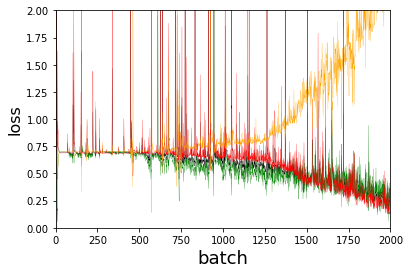

In [116]:
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot([x[0] for x in gan.g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, 2000)
plt.ylim(0, 2)

plt.show()


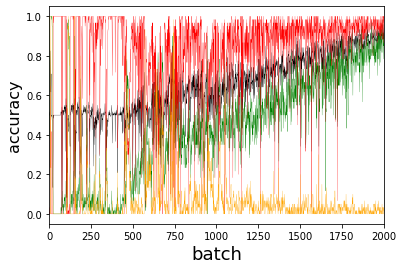

In [117]:
fig = plt.figure()
plt.plot([x[3] for x in gan.d_losses], color='black', linewidth=0.25)
plt.plot([x[4] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[5] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot([x[1] for x in gan.g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('accuracy', fontsize=16)

plt.xlim(0, 2000)

plt.show()